# NEON Tables 
## Table3 : NEON annual climate and fluxes.
  - Mean annual temperature and precipitaiton from datm data provided by NEON
  - Mean annual GPP and latent heat flux from CLM5.1 simulations (NEON data have too many gaps)

##### Author : Negin Sobhani negins@ucar.edu [@negin513](https://github.com/negin513)
##### Modified: Will Wieder wwieder@ucar.edu [@wwieder](https://github.com/wwieder)
##### Last revised: 2023-07-28
  - Adding latent heat flux and modified calculations to calculate annual means
  - subsequently taking mean and standard deviation of annual results.

Requires neon_preprocessor be run to calculate daily fluxes at each site.
_______

In [11]:
import os
import sys
import time

import numpy as np
import pandas as pd
import xarray as xr

from glob import glob
from os.path import join, expanduser

import matplotlib
import matplotlib.pyplot as plt

from scipy import stats
import tqdm
from neon_utils import download_eval_files
import matplotlib.colors as colors
import datetime
import warnings
warnings.filterwarnings("ignore")

In [12]:
print('xarray '+xr.__version__) ##-- was working with 0.20.0

xarray 2023.6.0


## Dask Cluster
The following will spin up a dask cluster,  only works on NCAR machines. 
4 workers worked best for NEON.

In [13]:
from distributed import Client
from ncar_jobqueue import NCARCluster

cluster = NCARCluster()
cluster.scale(4)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/45256/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/45256/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.49:38586,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/45256/status,Total threads: 0
Started: Just now,Total memory: 0 B


-------

In [14]:
# -- read list of sites:
#neon_sites_pft = pd.read_csv('/glade/scratch/wwieder/run_NEON_v2/tools/site_and_regional/neon_sites_dompft.csv')
neon_sites_pft = pd.read_csv('/glade/u/home/wwieder/CTSM/tools/site_and_regional/neon_sites_dompft.csv')
neon_sites = neon_sites_pft['Site'].to_list()


In [15]:
#neon_sites = ['BART']  # for testing
all_means = []
all_stds = []
all_sites = []
failed_sites = [] # -- list for saving failed sites
df_list =[]

years = ["2018","2019","2020","2021"]
tableVars = ['TBOT','PRECTmms','sim_GPP','sim_EFLX_LH_TOT']

for neon_site in tqdm.tqdm(neon_sites):
    try:
        # For datm files in run directories
        #atm_dir = "/glade/scratch/wwieder/NEON_testV2/"
        #atm_suf = neon_site+".transient/run/inputdata/atm/cdeps/v2/"
        #atm_path = os.path.join(atm_dir, atm_suf, neon_site)

        # For datm files dowloaded directly
        atm_dir = "/glade/campaign/cgd/tss/wwieder/NEON_v2/datm/"
        atm_path = os.path.join(atm_dir, neon_site)

        # Avoid reusing GPP results for missing sites
        # Won't use this now, but need to zero out GPP for NIWO and PUUM
        # this_df = []

        #read in preprocessed data from CLM simulations
        csv_dir = "/glade/scratch/wwieder/preprocessed_neon_v2/"
        csv_file = "preprocessed_"+neon_site+"*.csv"
        for f in glob((os.path.join(csv_dir, csv_file))):
            this_df = pd.read_csv(f)
        df_list.append(this_df)
        this_df['time'] = pd.to_datetime(this_df['time'],format= '%Y-%m-%d %H:%M:%S' )        

        atm_files = []

        for year in years:
             atm_files.extend(sorted(glob(join(atm_path,neon_site+"_atm_"+year+"*.nc"))))
                                          
        start = time.time()

        ds_atm = xr.open_mfdataset(atm_files, decode_times=True, combine='by_coords')

        end = time.time()        
        
        atm_vars = ['TBOT','PRECTmms']#,'RH','WIND','FSDS','FLDS']
        df = pd.DataFrame({'time':ds_atm.time})

        for var in atm_vars:
            field = np.ravel ( ds_atm[var])     
            df[var]=field
        
        # -- merge two pandas dataframe on time
        df=df.merge(this_df.set_index('time'), on='time', how='left')
        
        # Caclulate annual means
        this_stats = df[tableVars].groupby(df.time.dt.year).mean()

        # Convert units: MAT, K to C; 
        #                MAP, mm/s to mm/y; 
        #                GPP, gC/m2/d [calculated in preprocessing] to gC/m2/y
        this_stats['TBOT'] = this_stats.TBOT-273.15
        this_stats['PRECTmms'] = this_stats.PRECTmms*3600*24*365
        this_stats['sim_GPP'] = this_stats.sim_GPP*365

        # means and STD of annual means
        this_mean = np.around(this_stats.mean(),decimals=1) 
        this_std = np.around(this_stats.std(),decimals=2) 
        
        all_means.append(this_mean)
        all_stds.append(this_std)
        all_sites.append(neon_site)
            
    except Exception as e: 
        print (e)
        print ('THIS SITE FAILED:', neon_site)
        failed_sites.append(neon_site)
        pass


100%|██████████| 47/47 [01:41<00:00,  2.16s/it]


In [16]:
df_all = (pd.concat(all_means, axis = 1)).transpose()
df_all['site'] = all_sites
df_all = df_all.set_index('site')
# repeat for stds
df_all2 = (pd.concat(all_stds, axis = 1)).transpose()
df_all2['site'] = all_sites
df_all2 = df_all2.set_index('site')

df_all = pd.concat([df_all,df_all2], axis = 1)
df_all

,TBOT,PRECTmms,sim_GPP,sim_EFLX_LH_TOT,TBOT,PRECTmms,sim_GPP,sim_EFLX_LH_TOT
site,,,,,,,,
BART,7.7,1213.2,1126.8,33.6,0.71,146.33,56.97,1.30
HARV,8.5,1404.9,1153.1,32.3,0.61,502.62,53.46,1.85
BLAN,13.1,1299.0,1399.8,42.1,0.36,520.88,83.92,5.98
SCBI,13.0,1159.4,1457.7,43.5,0.42,312.94,75.92,2.05
SERC,14.3,1192.8,1410.9,35.8,0.33,507.21,162.66,3.05
DSNY,22.6,1369.9,2807.8,68.8,0.29,261.33,65.20,1.56
JERC,20.0,1416.4,2673.9,58.9,0.51,206.13,35.51,2.62
OSBS,21.3,1419.0,2650.1,59.1,0.36,419.94,16.92,1.65
GUAN,26.4,553.9,621.7,44.7,0.27,245.30,345.05,9.25


In [17]:
out_dir = "/glade/work/wwieder/neon_vis_plots/paper_plots_final/"

if not os.path.exists (out_dir):
    os.mkdir(out_dir)
    
out_file = os.path.join(out_dir, 'table3.csv')
print ('saving table in ', out_file)

df_all.to_csv(out_file)

saving table in  /glade/work/wwieder/neon_vis_plots/paper_plots_final/table3.csv


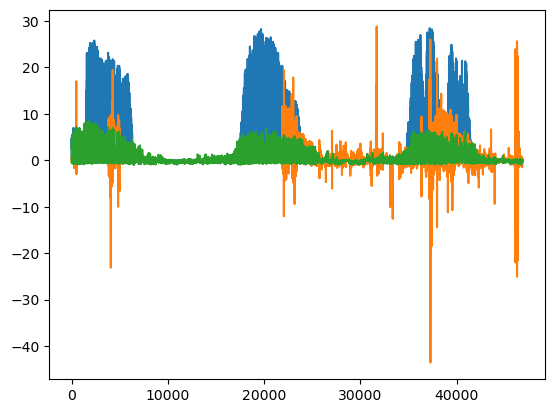

In [18]:
#(df.TBOT-273.15).plot(x='time')
df.sim_GPP.plot(x='time') ;
df.GPP.plot(x='time') ;
(df.Rnet/100).plot() ;


In [19]:
df_all

,TBOT,PRECTmms,sim_GPP,sim_EFLX_LH_TOT,TBOT,PRECTmms,sim_GPP,sim_EFLX_LH_TOT
site,,,,,,,,
BART,7.7,1213.2,1126.8,33.6,0.71,146.33,56.97,1.30
HARV,8.5,1404.9,1153.1,32.3,0.61,502.62,53.46,1.85
BLAN,13.1,1299.0,1399.8,42.1,0.36,520.88,83.92,5.98
SCBI,13.0,1159.4,1457.7,43.5,0.42,312.94,75.92,2.05
SERC,14.3,1192.8,1410.9,35.8,0.33,507.21,162.66,3.05
DSNY,22.6,1369.9,2807.8,68.8,0.29,261.33,65.20,1.56
JERC,20.0,1416.4,2673.9,58.9,0.51,206.13,35.51,2.62
OSBS,21.3,1419.0,2650.1,59.1,0.36,419.94,16.92,1.65
GUAN,26.4,553.9,621.7,44.7,0.27,245.30,345.05,9.25


In [20]:
neon_sites

['BART',
 'HARV',
 'BLAN',
 'SCBI',
 'SERC',
 'DSNY',
 'JERC',
 'OSBS',
 'GUAN',
 'LAJA',
 'STEI',
 'TREE',
 'UNDE',
 'KONA',
 'KONZ',
 'UKFS',
 'GRSM',
 'MLBS',
 'ORNL',
 'DELA',
 'LENO',
 'TALL',
 'DCFS',
 'NOGP',
 'WOOD',
 'CPER',
 'RMNP',
 'STER',
 'CLBJ',
 'OAES',
 'YELL',
 'MOAB',
 'NIWO',
 'JORN',
 'SRER',
 'ONAQ',
 'ABBY',
 'WREF',
 'SJER',
 'SOAP',
 'TEAK',
 'TOOL',
 'BARR',
 'BONA',
 'DEJU',
 'HEAL',
 'PUUM']